In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sionehoghen/facial-expression")

print("Path to dataset files:", path)

In [2]:
 !nvidia-smi

Mon Dec  9 05:32:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-12-09 05:32:33--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2024-12-09 05:32:33--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc19c600f03204751142972ff538.dl.dropboxusercontent.com/cd/0/inline/Cf6sC_pt7z6fbXkoGvjlvECpHXfi6KtdgEPeZPx1p6Mp6RIKNzJ0repG1eie1h1kOnxl_Ivvsn4S2KDXA_KZq04-QL3EaBx0AQ1Ym5C4b7RfoVvVdWRc8yzlIaiVC2CRZlCISlD3hkfmOso-AyhJa1-_/file# [following]
--2024-12-09 05:32:33--  https://uc19c600f03204751142972ff538.dl.dropboxusercontent.com/cd/0/inline/Cf6s

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing

tf.random.set_seed(4)

In [7]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [8]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x), train_image_paths))

train_image_paths[:10]

['/content/train/disgust/Training_50997276.jpg',
 '/content/train/disgust/Training_73540712.jpg',
 '/content/train/disgust/Training_60623627.jpg',
 '/content/train/disgust/Training_80671795.jpg',
 '/content/train/disgust/Training_14064382.jpg',
 '/content/train/disgust/Training_77446866.jpg',
 '/content/train/disgust/Training_41001987.jpg',
 '/content/train/disgust/Training_8819879.jpg',
 '/content/train/disgust/Training_96544137.jpg',
 '/content/train/disgust/Training_37855272.jpg']

In [9]:
def get_label(image_path):
  return image_path.split("/")[-2]
train_image_labels = list(map(get_label, train_image_paths))
train_image_labels[:10]

['disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust']

In [10]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
train_image_labels[:10]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [14]:
 from sklearn.model_selection import train_test_split

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.2)

In [15]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e, weight in enumerate(classWeight)}
print(class_weight)

{0: 1.808624488511174, 1: 16.752186588921283, 2: 1.7642001842186061, 3: 1.0, 4: 1.4329177057356608, 5: 1.479021879021879, 6: 2.2542173401333856}


In [16]:
def load(image, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  return image, label

In [24]:
IMG_SIZE = 96
BATCH_SIZE = 32

resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
])

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load(image, label):
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  return image, label

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [33]:
%time train_dataset = get_dataset(Train_paths , Train_labels)

def load(image, label):
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  return image, label

CPU times: user 228 ms, sys: 6.12 ms, total: 234 ms
Wall time: 237 ms


happy


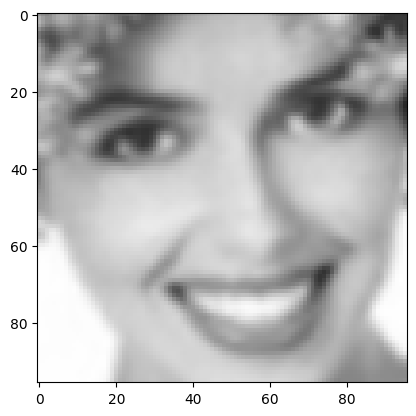

In [54]:
image, label = next(iter(train_dataset))

print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [55]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 58.3 ms, sys: 1.89 ms, total: 60.2 ms
Wall time: 60 ms
(32, 96, 96, 3)
(32, 7)


happy


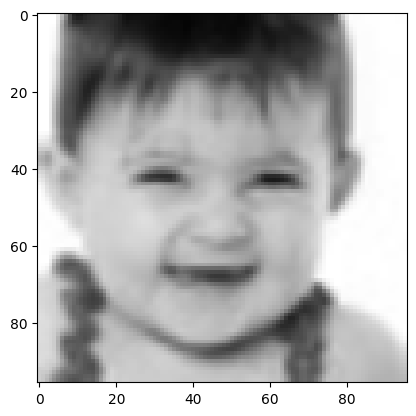

In [56]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [57]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [59]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
717/717 ━━━━━━━━━━━━━━━━━━━━ 182s 98ms/step - accuracy: 0.3320 - loss: 3.0684 - precision: 0.5709 - recall: 0.1251 - val_accuracy: 0.3752 - val_loss: 1.6700 - val_precision: 0.6039 - val_recall: 0.1720
Epoch 2/12
717/717 ━━━━━━━━━━━━━━━━━━━━ 137s 97ms/step - accuracy: 0.4828 - loss: 2.4432 - precision: 0.6812 - recall: 0.2727 - val_accuracy: 0.4902 - val_loss: 1.3795 - val_precision: 0.6289 - val_recall: 0.2879
Epoch 3/12
717/717 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.5185 - loss: 2.2193 - precision: 0.6896 - recall: 0.3151 - val_accuracy: 0.5310 - val_loss: 1.2504 - val_precision: 0.6957 - val_recall: 0.3869
Epoch 4/12
717/717 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - accuracy: 0.5461 - loss: 2.1281 - precision: 0.7221 - recall: 0.3639 - val_accuracy: 0.5606 - val_loss: 1.1765 - val_precision: 0.7255 - val_recall: 0.3823
Epoch 5/12
717/717 ━━━━━━━━━━━━━━━━━━━━ 61s 86ms/step - accuracy: 0.5603 - loss: 2.0416 - precision: 0.7274 - recall: 0.3775 - val_accuracy: 0.5636 - 

In [60]:
model.layers[0].trainable = False

In [65]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [66]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,714,324 (90.46 MB)

 Trainable params: 181,255 (708.03 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 15,764,500 (60.14 MB)

In [67]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6248 - loss: 1.6720 - precision: 0.7540 - recall: 0.4878
Epoch 1: val_loss improved from inf to 1.09597, saving model to best_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.6248 - loss: 1.6721 - precision: 0.7540 - recall: 0.4878 - val_accuracy: 0.5999 - val_loss: 1.0960 - val_precision: 0.7095 - val_recall: 0.4899
Epoch 2/8
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6387 - loss: 1.6130 - precision: 0.7573 - recall: 0.5039
Epoch 2: val_loss improved from 1.09597 to 1.03000, saving model to best_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 63s 89ms/step - accuracy: 0.6387 - loss: 1.6131 - precision: 0.7573 - recall: 0.5039 - val_accuracy: 0.6236 - val_loss: 1.0300 - val_precision: 0.7096 - val_recall: 0.5310
Epoch 3/8
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6425 - loss: 1.5748 - precision: 0.7602 - recall: 0.5181
Epoch 3: val_loss did not improve from 1.03000
71

Testing Phase

In [68]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [70]:
model.load_weights("best_weights.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 608 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [72]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


disgust


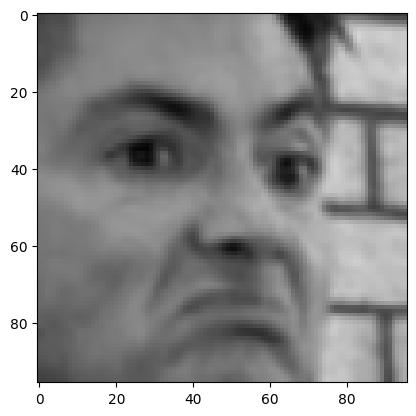

In [73]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [74]:
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.4534 - loss: 1.6048 - precision: 0.6127 - recall: 0.2903
 Testing Acc :  0.3335190713405609
 Testing Precision  0.4879084825515747
 Testing Recall  0.2079966515302658


Save Objects

In [75]:
model.save("FacialExpressionModel.h5")

In [76]:
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [77]:
save_object(Le, "LabelEncoder")